In [1]:
import pandas as pd 
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import pickle
import gensim 
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder 
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay

In [2]:
data = pd.read_csv(r"C:\Users\ruth\Documents\software courses\3rd year\2nd Semester\Fundamental Of Machine Learning\Assignment\Hate-Speech-Detection\Data\twitter_data.csv")
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [3]:
data['label'] = data['class'].map({0:"Hate Speech Detected",1:"Hate Speech Detected",2:"No Hate speech"})
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,label
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,No Hate speech
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Hate Speech Detected
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Hate Speech Detected
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Hate Speech Detected
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Hate Speech Detected


In [4]:
# defining a function for data processing
def data_processing(data):
    data = data.lower()
    data = re.sub(r"https\S+|www\S+http\S+", '', data)
    data = re.sub(r'\@w+|\#','', data)
    data = re.sub(r'[^\w\s]','',data)
    data = re.sub(r'ð','',data)
    return data 

In [5]:
data.tweet = data['tweet'].apply(data_processing)

In [6]:
data = data.drop_duplicates('tweet')

In [7]:
def lemmatize(token):
    return WordNetLemmatizer().lemmatize(token, pos='v')

def tokenize(tweet):
    result = []
    for token in gensim.utils.simple_preprocess(tweet):
        if token not in gensim.parsing.preprocessing.STOPWORDS \
                and len(token) > 2: 
            result.append(lemmatize(token))
    return result

def tokenize_and_lemmatize(df, col):
    df[col] = df[col].apply(lambda x: tokenize(x))
    df.tweet = df.tweet.apply(lambda x: str(x)[1:-1])

tokenize_and_lemmatize(data, 'tweet')
data.tweet.head(20)

0     'mayasolovely', 'woman', 'shouldnt', 'complain...
1     'mleew', 'boy', 'dats', 'coldtyga', 'dwn', 'ba...
2     'urkindofbrand', 'dawg', 'sbaby', 'life', 'fuc...
3     'c_g_anderson', 'viva_based', 'look', 'like', ...
4     'shenikaroberts', 'shit', 'hear', 'true', 'fak...
5     't_madison_x', 'shit', 'blow', 'meclaim', 'fai...
6           'sit', 'hate', 'bitch', 'get', 'shit', 'go'
7     'selfiequeenbri', 'cause', 'tire', 'big', 'bit...
8                        'amp', 'bitch', 'amp', 'thats'
9     'rhythmixx_', 'hobbies', 'include', 'fight', '...
10    'keeks', 'bitch', 'curve', 'lol', 'walk', 'con...
11             'murda', 'gang', 'bitch', 'gang', 'land'
12                      'hoe', 'smoke', 'losers', 'yea'
13                      'bad', 'bitch', 'thing', 'like'
14                                              'bitch'
15                             'bitch', 'nigga', 'miss'
16                                       'bitch', 'plz'
17                                      'bitch',

In [8]:
print(data['tweet'].iloc[0],"\n")
print(data['tweet'].iloc[1],"\n")
print(data['tweet'].iloc[2],"\n")
print(data['tweet'].iloc[3],"\n")
print(data['tweet'].iloc[4],"\n")

'mayasolovely', 'woman', 'shouldnt', 'complain', 'clean', 'house', 'amp', 'man', 'trash' 

'mleew', 'boy', 'dats', 'coldtyga', 'dwn', 'bad', 'cuffin', 'dat', 'hoe', 'place' 

'urkindofbrand', 'dawg', 'sbaby', 'life', 'fuck', 'bitch', 'start', 'confuse', 'shit' 

'c_g_anderson', 'viva_based', 'look', 'like', 'tranny' 

'shenikaroberts', 'shit', 'hear', 'true', 'faker', 'bitch', 'tell' 



In [9]:
data[['tweet','label']].head()

,tweet,label
0,"'mayasolovely', 'woman', 'shouldnt', 'complain...",No Hate speech
1,"'mleew', 'boy', 'dats', 'coldtyga', 'dwn', 'ba...",Hate Speech Detected
2,"'urkindofbrand', 'dawg', 'sbaby', 'life', 'fuc...",Hate Speech Detected
3,"'c_g_anderson', 'viva_based', 'look', 'like', ...",Hate Speech Detected
4,"'shenikaroberts', 'shit', 'hear', 'true', 'fak...",Hate Speech Detected


In [10]:
data['label'].value_counts()

Hate Speech Detected    20582
No Hate speech           4161
Name: label, dtype: int64

<AxesSubplot: xlabel='label', ylabel='count'>

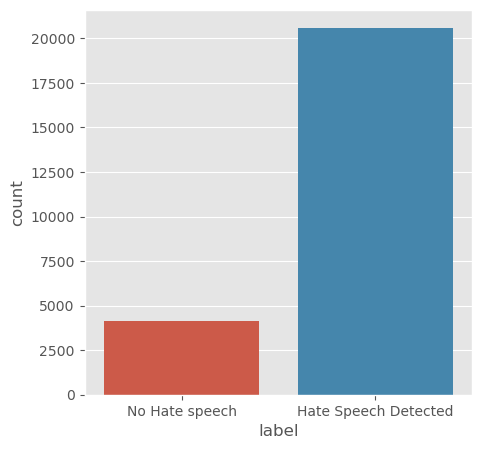

In [11]:
style.use('ggplot')
fig = plt.figure(figsize=(5,5))
sns.countplot(x='label', data = data)

In [12]:
cv = CountVectorizer()
X=cv.fit_transform(data['tweet'])
Y=LabelEncoder().fit_transform(data['label']) 

In [13]:
X_train,x_test,Y_train,y_test = train_test_split(X,Y,test_size=0.2)

In [14]:
model=svm.SVC(kernel='linear').fit(X_train,Y_train)
pred = model.predict(x_test)
model_accuracy = accuracy_score(pred,y_test)
print("Model Accuracy: {:.2f}%".format(model_accuracy*100))

Model Accuracy: 95.09%


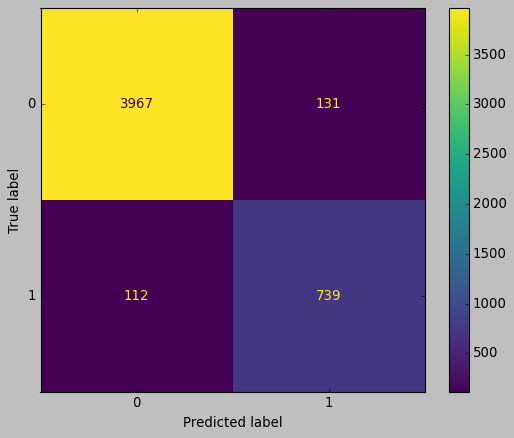

In [15]:
style.use('classic')
cm = confusion_matrix(y_test, pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()

In [16]:
# model using tfidVectorizer
tfid = TfidfVectorizer()
X_t=tfid.fit_transform(data['tweet'])
Y_t=LabelEncoder().fit_transform(data['label']) 

In [17]:
X_train_t,x_test_t,Y_train_t,y_test_t = train_test_split(X_t,Y_t,test_size=0.2)

In [18]:
model_t =svm.SVC(kernel='linear').fit(X_train_t,Y_train_t)
pred_t = model_t.predict(x_test_t)
model_accuracy = accuracy_score(pred_t,y_test_t)
print("Model Accuracy: {:.2f}%".format(model_accuracy*100))

Model Accuracy: 95.53%


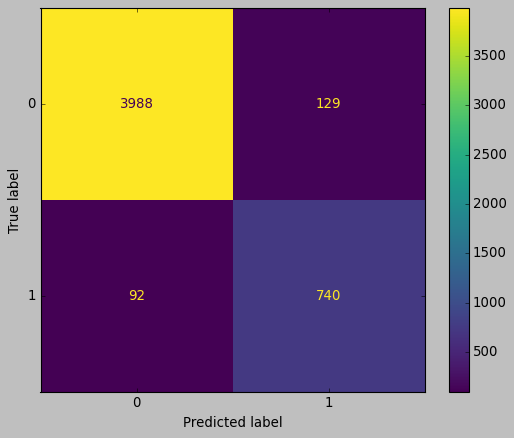

In [19]:
style.use('classic')
cm_t = confusion_matrix(y_test_t, pred_t, labels=model_t.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_t,display_labels=model_t.classes_)
disp.plot()

In [20]:
pickle.dump(model,open('SVM model.pkl','wb'))